# Code for Detection and Curation of Diabetic Retinopathy

In [ ]:
%cd "/content/drive/My Drive/Minor Project/B. Disease Grading"

/content/drive/My Drive/Minor Project/B. Disease Grading


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ls

'1. Original Images'/   IRDID.ipynb   pyimagesearch/   y_train.npy
'2. Groundtruths'/      lenet.model   X_test.npy
 CC-BY-4.0.txt          LICENSE.txt   X_train.npy
 CNN.ipynb              plot.png      y_test.npy


In [ ]:
ls '2. Groundtruths'

'a. IDRiD_Disease Grading_Training Labels.csv'   TP.ipynb
'b. IDRiD_Disease Grading_Testing Labels.csv'


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
training_df = pd.read_csv("2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv")
test_df = pd.read_csv("2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv")

In [ ]:
test_df.sample(5)

,Image name,Retinopathy grade,Risk of macular edema
36,IDRiD_037,0,0
62,IDRiD_063,1,0
31,IDRiD_032,4,1
53,IDRiD_054,0,0
94,IDRiD_095,0,0


In [ ]:
training_df.describe()

,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
count,413.000000,413.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.719128,1.043584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.387723,0.949215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Select only reqd cols
training_df = training_df.iloc[:,0:3]

# rename col at get rid of extra space at end
training_df.rename(columns={'Risk of macular edema ':'Risk of macular edema'}, inplace=True)

# If value >0 update row's value to 1
training_df.loc[training_df['Retinopathy grade'] > 0, ['Retinopathy grade']] = 1
training_df.loc[training_df['Risk of macular edema'] > 0, ['Risk of macular edema']] = 1

In [ ]:
# Select only reqd cols
test_df = test_df.iloc[:,0:3]

# rename col at get rid of extra space at end
test_df.rename(columns={'Risk of macular edema ':'Risk of macular edema'}, inplace=True)

# If value >0 update row's value to 1
test_df.loc[test_df['Retinopathy grade'] > 0, ['Retinopathy grade']] = 1
test_df.loc[test_df['Risk of macular edema'] > 0, ['Risk of macular edema']] = 1

In [ ]:
training_df.loc[:,'Retinopathy grade':]

,Retinopathy grade,Risk of macular edema
0,1,1
1,1,1
2,1,1
3,1,1
4,1,0
...,...,...
408,1,1
409,1,0
410,1,0
411,1,0


In [ ]:
test_df.head()

,Image name,Retinopathy grade,Risk of macular edema
0,IDRiD_001,1,0
1,IDRiD_002,1,1
2,IDRiD_003,1,0
3,IDRiD_004,1,0
4,IDRiD_005,1,1


# ls '1. Original Images/a. Training Set'

In [ ]:
y_train = training_df.loc[:,'Retinopathy grade':].values
y_train.shape

(413, 2)

In [ ]:
y_test = test_df.loc[:,'Retinopathy grade':].values
y_test.shape

(103, 2)

In [ ]:
from keras.preprocessing.image import  array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [ ]:
from tqdm import tqdm

In [ ]:
train_path ='1. Original Images/a. Training Set'
test_path = '1. Original Images/b. Testing Set'

IMG_SIZE = (224,224)

X_train = []
X_test = []

def create_data():
    print("Train data")
    for i in tqdm(training_df["Image name"]):
        img_train = load_img(train_path+'/'+i+'.jpg').resize(IMG_SIZE)
        img_train = img_to_array(img_train)
        X_train.append(img_train)    
    
    print("Test data")
    for j in tqdm(test_df["Image name"]):
        img_test = load_img(test_path+'/'+j+'.jpg').resize(IMG_SIZE)
        img_test = img_to_array(img_test)
        X_test.append(img_test)

In [ ]:
create_data()

  0%|          | 0/413 [00:00<?, ?it/s]

Train data


  0%|          | 0/103 [00:00<?, ?it/s]

Test data


100%|██████████| 103/103 [01:35<00:00,  1.07it/s]


In [ ]:
X_train = np.array(X_train)/255.0
X_test = np.array(X_test)/255.0

In [ ]:
X_test.shape

(103, 224, 224, 3)

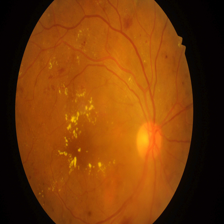

In [ ]:
array_to_img(X_train[0])

In [ ]:
X_train.shape , y_train.shape
X_test.shape , y_test.shape

((103, 224, 224, 3), (103, 2))

In [ ]:
np.save("X_train.npy",X_train)
np.save("X_test.npy",X_test)
np.save("y_train.npy",y_train)
np.save("y_test.npy",y_test)

In [ ]:
###### MODEL #########
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.9)(x)

predictions = Dense(2, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# model.add(Dropout(0.2))

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
ls

'1. Original Images'/   IRDID.ipynb   pyimagesearch/   y_train.npy
'2. Groundtruths'/      lenet.model   X_test.npy
 CC-BY-4.0.txt          LICENSE.txt   X_train.npy
 CNN.ipynb              plot.png      y_test.npy


In [ ]:
X_train,X_test = np.load("X_train.npy") , np.load("X_test.npy")

y_train , y_test = np.load("y_train.npy"),np.load("y_test.npy")

In [ ]:
X_train , X_test = preprocess_input(X_train) , preprocess_input(X_test)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
13/13 [==============================] - 4s 311ms/step - loss: 0.7958 - accuracy: 0.4988 - val_loss: 0.7228 - val_accuracy: 0.3204
Epoch 2/5
13/13 [==============================] - 3s 199ms/step - loss: 0.7738 - accuracy: 0.5061 - val_loss: 0.7199 - val_accuracy: 0.6311
Epoch 3/5
13/13 [==============================] - 3s 198ms/step - loss: 0.7700 - accuracy: 0.5061 - val_loss: 0.7172 - val_accuracy: 0.9126
Epoch 4/5
13/13 [==============================] - 3s 199ms/step - loss: 0.7746 - accuracy: 0.5278 - val_loss: 0.7147 - val_accuracy: 0.9806
Epoch 5/5
13/13 [==============================] - 3s 198ms/step - loss: 0.7668 - accuracy: 0.5061 - val_loss: 0.7122 - val_accuracy: 1.0000


In [ ]:
s= model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 108ms/step - loss: 0.7122 - accuracy: 1.0000


In [ ]:
s

[0.7121749520301819, 1.0]

In [ ]:
y_test[0]

array([1, 0])

In [ ]:
model.predict(np.expand_dims(X_test[0],axis = 0))

array([[0.4563105 , 0.45357528]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

In [ ]:
EPOCHS = 10
BS = 32

H = model.fit_generator(
	aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test),
	steps_per_epoch=len(X_train) // BS,
	epochs=EPOCHS,
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
12/12 [==============================] - 5s 417ms/step - loss: 0.7645 - accuracy: 0.4714 - val_loss: 0.7100 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 5s 421ms/step - loss: 0.7704 - accuracy: 0.4803 - val_loss: 0.7080 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 5s 415ms/step - loss: 0.7516 - accuracy: 0.4751 - val_loss: 0.7062 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 5s 417ms/step - loss: 0.7501 - accuracy: 0.5591 - val_loss: 0.7043 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 5s 425ms/step - loss: 0.7599 - accuracy: 0.4908 - val_loss: 0.7026 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 5s 418ms/step - loss: 0.7667 - accuracy: 0.5249 - val_loss: 0.7009 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 5s 412ms/step - loss

In [ ]:
model.evaluate(X_test , y_test)

4/4 [==============================] - 0s 104ms/step - loss: 0.6614 - accuracy: 0.9903


[0.6614357829093933, 0.9902912378311157]